In [8]:
 !pip install -q --upgrade optuna 

In [9]:
import optuna

optuna.__version__

'4.2.1'

# Подбор гиперпараметров - optuna

## Часть 0. Пара слов про `sklearn.model_selection`, GridSearch, RandomizedSearch

In [10]:
# вывод?

## Часть 1. optuna - быстрый взгляд на базовый пайплайн

[optuna](https://github.com/optuna/optuna) - библиотека для оптимизации НЕдифференцируемых функций

Создадим данные - задача бинарной классификации для линейных моделей

In [11]:
import numpy as np, pandas as pd
from IPython.display import display

n = 10_000
X = np.random.randn(n, 10)
valuable_features = [0, 1, 4, 5, 8]

# y = sign(f0 + f1 + f4 + f5 + f8)
noise = np.random.randn(n) / 5
y = ((X[:, valuable_features].sum(axis=1) + noise) > 0).astype(np.uint8) 

display(pd.Series(y).value_counts())

from sklearn.model_selection import train_test_split

X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.3, stratify=y, shuffle=True, random_state=911)

0    5034
1    4966
Name: count, dtype: int64

### Базовый пайплайн

In [12]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score


def my_objective(
    trial: optuna.trial.Trial, # нечто оптюновское
    
    X_tr, X_val, y_tr, y_val # данные
):
    '''
    Принимает на вход трейн и валидацию.
    Обучает модель на предложенном наборе гиперпараметров (предлагает optuna) и считает accuracy
    
    returns: accuracy_score
    '''
    # некоторые гиперпараметры мы фиксируем, некоторые "предлагаем" из заданных нами распределений
    params = {
        'loss': trial.suggest_categorical('loss', ['log_loss', 'hinge']),
        'alpha': trial.suggest_float('alpha', 1e-5, 1, log=True, step=None), # еще есть suggest_int
        'learning_rate': 'constant',
        'eta0': trial.suggest_float('eta0', 1e-5, 1, log=True, step=None),
    }
    # создаем и обучаем модель на предложенных и фиксированных гиперпараметрах
    model = SGDClassifier(**params)
    model.fit(X_tr, y_tr)
    
    # предсказываем на валидации [/ кроссвалидации] и получаем скор - считаем метрику качества
    y_pred = model.predict(X_val)
    if params['loss'] == 'log_loss':
        y_pred = (y_pred > 0.5).astype(int) # никогда бездумно не отсекайте по порогу 0.5! это просто пример
    score = accuracy_score(y_val, y_pred)
    
    return score # возвращает одно значение - скор

In [13]:
study = optuna.create_study(sampler=None, direction='maximize')

from functools import partial

# Нужно сделать так, чтобы наша функция-objective в итоге принимала только аргумент trial.
# Поэтому зафиксируем заранее все остальные
obj_func = partial(my_objective, X_tr=X_tr, X_val=X_val, y_tr=y_tr, y_val=y_val)

study.optimize(obj_func, n_trials=100, n_jobs=3, gc_after_trial=True) # есть еще аргумент timeout. optimize можно отсановить через Ctrl + C (кнопка стоп на панели ноутбука) с сохранением всей истории

[I 2025-04-08 20:28:47,169] A new study created in memory with name: no-name-762378b6-5e6d-4a6b-813e-dbf951c7d8ea
[I 2025-04-08 20:28:47,185] Trial 2 finished with value: 0.9576666666666667 and parameters: {'loss': 'log_loss', 'alpha': 0.004016942395186128, 'eta0': 0.08120188837422851}. Best is trial 2 with value: 0.9576666666666667.
[I 2025-04-08 20:28:47,187] Trial 0 finished with value: 0.9586666666666667 and parameters: {'loss': 'log_loss', 'alpha': 0.0078866135867431, 'eta0': 0.3052788620219798}. Best is trial 0 with value: 0.9586666666666667.
[I 2025-04-08 20:28:47,388] Trial 1 finished with value: 0.9706666666666667 and parameters: {'loss': 'log_loss', 'alpha': 0.0005011592993764799, 'eta0': 0.014806838595976849}. Best is trial 1 with value: 0.9706666666666667.
[I 2025-04-08 20:28:47,482] Trial 4 finished with value: 0.9726666666666667 and parameters: {'loss': 'hinge', 'alpha': 0.005434757228379619, 'eta0': 0.0004846973271090103}. Best is trial 4 with value: 0.9726666666666667.


In [14]:
from optuna.visualization import plot_slice

plot_slice(study)

пара слов про `log=True`

In [15]:
def dummy_objective(trial):
    val = trial.suggest_float('val', 1e-5, 100, log=False)
    return 1
    
optuna.logging.set_verbosity(optuna.logging.WARNING)
dummy_study = optuna.create_study()
dummy_study.optimize(dummy_objective, n_trials=100)

In [16]:
plot_slice(study)

# Часть 2. Базовый пайплайн - разбор составляющих

### модуль [`optuna`](https://optuna.readthedocs.io/en/v3.4.0/reference/optuna.html)

содержит несколько методов для создания / загрузки / удаления / ... объекта `optuna.study.Study`

### модуль [`optuna.study`](https://optuna.readthedocs.io/en/v3.4.0/reference/study.html)

содержит почти то же самое + класс `optuna.study.Study`


`optuna.study.Study` - объект-"оптимизационная сессия"
- создается с помощью `optuna.create_study(...)`
- `optuna.study.Study.optimize` - запуск оптимизационной сессии
- cодержит информацию о всех trials
- *ask-tell интерфейс

In [17]:
type(study.trials)

list

In [18]:
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_alpha,params_eta0,params_loss,state
0,0,0.958667,2025-04-08 20:28:47.171459,2025-04-08 20:28:47.187459,0 days 00:00:00.016000,0.007887,0.305279,log_loss,COMPLETE
1,1,0.970667,2025-04-08 20:28:47.173459,2025-04-08 20:28:47.388284,0 days 00:00:00.214825,0.000501,0.014807,log_loss,COMPLETE
2,2,0.957667,2025-04-08 20:28:47.174459,2025-04-08 20:28:47.184457,0 days 00:00:00.009998,0.004017,0.081202,log_loss,COMPLETE
3,3,0.922333,2025-04-08 20:28:47.290107,2025-04-08 20:28:47.571185,0 days 00:00:00.281078,0.014003,0.143619,log_loss,COMPLETE
4,4,0.972667,2025-04-08 20:28:47.386284,2025-04-08 20:28:47.482282,0 days 00:00:00.095998,0.005435,0.000485,hinge,COMPLETE
...,...,...,...,...,...,...,...,...,...
95,95,0.973667,2025-04-08 20:28:56.305061,2025-04-08 20:28:56.430730,0 days 00:00:00.125669,0.001065,0.000555,log_loss,COMPLETE
96,96,0.974000,2025-04-08 20:28:56.392730,2025-04-08 20:28:56.431733,0 days 00:00:00.039003,0.000259,0.000596,log_loss,COMPLETE
97,97,0.974000,2025-04-08 20:28:56.516337,2025-04-08 20:28:56.814054,0 days 00:00:00.297717,0.000190,0.000376,log_loss,COMPLETE
98,98,0.973000,2025-04-08 20:28:56.604480,2025-04-08 20:28:56.729480,0 days 00:00:00.125000,0.000102,0.001159,log_loss,COMPLETE


### модуль [`optuna.trial`](https://optuna.readthedocs.io/en/v3.4.0/reference/trial.html)

содержит `optuna.trial.Trial` и его вариации в разные моменты времени

`optuna.trial.Trial` - объект-"попытка".
- отвечает за конкретный предложенный набор гиперпараметров
- содержит информацию о том, какие гиперпаметры были предложены в текущей попытке
- содержит информацию о полученном score

In [19]:
study.trials[0]

FrozenTrial(number=0, state=1, values=[0.9586666666666667], datetime_start=datetime.datetime(2025, 4, 8, 20, 28, 47, 171459), datetime_complete=datetime.datetime(2025, 4, 8, 20, 28, 47, 187459), params={'loss': 'log_loss', 'alpha': 0.0078866135867431, 'eta0': 0.3052788620219798}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'loss': CategoricalDistribution(choices=('log_loss', 'hinge')), 'alpha': FloatDistribution(high=1.0, log=True, low=1e-05, step=None), 'eta0': FloatDistribution(high=1.0, log=True, low=1e-05, step=None)}, trial_id=0, value=None)

In [20]:
# атрибуты trial.Trial
for attr in dir(study.best_trial):
    if attr[0] != '_':
        print(attr)

datetime_complete
datetime_start
distributions
duration
intermediate_values
last_step
number
params
report
set_system_attr
set_user_attr
should_prune
state
suggest_categorical
suggest_discrete_uniform
suggest_float
suggest_int
suggest_loguniform
suggest_uniform
system_attrs
user_attrs
value
values


In [21]:
study.best_trial.params # предложенные гиперпараметры

{'loss': 'log_loss',
 'alpha': 0.00015198724892329029,
 'eta0': 0.000841466986687873}

In [22]:
study.best_trial.value # полученный на них score - то, что возвращает my_objective

0.974

### модуль [`optuna.visualization`](https://optuna.readthedocs.io/en/v3.4.0/reference/visualization/index.html)

содержит разные способы визуализировать прошедшую оптимизационную сессию - study

По умолчанию использует [plotly](https://plotly.com/python/), но можно использовать matplotlib, используя `optuna.visualization.matplotlib`

**`plot_slice`**

In [23]:
from optuna.visualization import plot_slice

plot_slice(study, target_name='accuracy')

# из-за сильно маленьких значений objective у нас едет масштаб - можно зазумиться в нужную зону на графиках...

In [24]:
# ...а можно сразу обрезать не интересующие нас значения

def my_clipper(trial: optuna.trial.FrozenTrial):
    score = trial.value
    return max(0.96, score)
    
plot_slice(study, target=my_clipper, target_name='accuracy. 0.96-clip')

**`plot_contour`**

In [25]:
from optuna.visualization import plot_contour

plot_contour(study)

In [26]:
fig = plot_contour(study, params=['eta0', 'alpha'], target=my_clipper, target_name='accuracy')
fig.update_layout(width=900, height=600)

**`plot_rank`**

In [27]:
from optuna.visualization import plot_rank

plot_rank(study)

In [28]:
plot_rank(study, params=['alpha', 'eta0'], target=my_clipper, target_name='accuracy')

**`plot_intermediate_values`**

In [29]:
def intermediate_objective(trial):
    for i in range(10): # предположим, что это градиентный спуск
        # шаг спуска
        pass
        # мерим скор после шага
        score = trial.number * i
        # записываем, что на шаге step был скор score. Не обязательно записывать именно скор :)
        trial.report(score, step=i)  
    return np.random.randint(0, 5) # по приколу. что-то надо вернуть

study = optuna.create_study(direction='maximize')
study.optimize(intermediate_objective, n_trials=5)

from optuna.visualization import plot_intermediate_values

plot_intermediate_values(study)

остальное довольно специфично - изучайте сами :)

### модуль [`optuna.samplers`](https://optuna.readthedocs.io/en/v3.4.0/reference/samplers/index.html)

содержит сэмплеры - объекты-"предлагатели гиперпараметров"
- `optuna.samplers.BaseSampler` - базовый класс для создания сэмплеров. Также содержит инструкцию по их структуре
- `optuna.samplers.GridSampler`, `optuna.samplers.RandomSampler` - куда же без них
- `optuna.samplers.TPESampler` - база, основа, столб
- `optuna.samplers.CmaEsSampler` - навороченный сэмплер для оптимизации числовых функций (не для обучения моделей)
- `optuna.samplers.[NSGAIISampler, NSGAIIISampler]` - сэмплеры для multiobjective-оптимизации (не для обучения моделей)
- `optuna.samplers.MOTPESampler` - сэмплер для multiobjective-оптимизации, годный для обучения моделей
- остальное...


сэмплеры делятся на два типа:
- используется метод `sampler.sample_independent`, НЕ учитывается возможная связь между предлагаемыми гиперпараметрами
    - `optuna.samplers.GridSampler`, `optuna.samplers.RandomSampler`
    - `optuna.samplers.TPESampler` в базовом виде
    
    
- используется метод `sampler.sample_relative`, учитывается возможная связь между предлагаемыми гиперпараметрами
    - `optuna.samplers.CmaEsSampler`
    - `optuna.samplers.TPESampler` - его [BOHB](http://proceedings.mlr.press/v80/falkner18a.html)-вариация. TPESampler(..., multivariate=True)
    
структура сэмплера:
- метод `sampler.before_trial` - trial pre-processing
- метод `sampler.sample_...` - сэмплирование гиперпараметров
- метод `sampler.after_trial` - trial post-processing

## Часть 3. TPESampler - Tree-structured Parzen Estimator algorithm


[`optuna.samplers.TPESampler`](https://optuna.readthedocs.io/en/v3.4.0/reference/samplers/generated/optuna.samplers.TPESampler.html)

  2011 - [Algorithms for Hyper-Parameter Optimization](https://proceedings.neurips.cc/paper/2011/file/86e8f7ab32cfd12577bc2619bc635690-Paper.pdf) <br>
  2013 - [Making a Science of Model Search: Hyperparameter Optimization
in Hundreds of Dimensions for Vision Architectures](http://proceedings.mlr.press/v28/bergstra13.pdf)<br>
для понимания некоторых параметров `optuna.samplers.TPESampler` - Section 5. Results

плюсы:
- independent
- relative
- поддерживает категориальные гиперпараметры
- поддерживает `conditional search space`
- с 3.4.0 позволяет задать расстояния на категориальных гиперпараметрах
- поддерживает multiobjective-оптимизацию

минусы:
0_0

In [30]:
# conditional search space
def dummy_objective(trial, *args):
    model_type = trial.suggest_categorical('smth', ['linear', 'neural_network'])
    if model_type == 'linear':
        reg_lambda = trial.suggest_float(...)
        # ...
    else:
        num_layers = trial.suggest_int(...)
        # ...
    return 1

### TPESampler. Сэмплируем с умом - как это работает

[описание с картинками](http://neupy.com/2016/12/17/hyperparameter_optimization_for_neural_networks.html#tree-structured-parzen-estimators-tpe)

- Сэмплируем `n_startup_trials` рандом сэмплером и считаем скоры


- После этой "подготовки" имеем для каждого гиперпараметра `n_startup_trials` пар (hyp_value, score)


- Дальше будем предлагать по-умному. Для каждого гиперпараметра, значение которого мы хотим предложить, делаем:
    - <img src="http://neupy.com/_images/tpe-observation-groups.png" />
    - Выбираем `gamma` hyp_values с наилучшим score и строим их KDE с гауссовским ядром - p_best(x)
    - Строим KDE с гауссовским ядром остальных-плохих hyp_values - p_worst(x) <br>
    <img src="http://neupy.com/_images/tpe-sampled-candidates.png" width="700"/>
    - Сэмплируем из p_best(x) `n_ei_candidates` новых hyp_values - кандидатов на предложение
    - Для каждого из кандидатов имеем p_best(candidate) и p_worst(candidate) - ТИПА вероятности принадлежности кандидата к каждой из двух групп
    <img src="http://neupy.com/_images/tpe-expected-improvement.png" width="700"/>
    - Предлагаем кандидата с максимальным p_best(candidate) / p_worst(candidate)





In [31]:
# TPESampler используется по умолчанию с параметрами по умолчанию
# Его почти всегда надо настраивать

n_trials = 200
tpe_sampler = optuna.samplers.TPESampler(
    n_startup_trials=n_trials/2, # объем разведки. Всегда настраивайте!
    gamma=lambda n_trials: min(int(np.ceil(0.1 * n_trials)), 25), # не обязательно настраивать. По умолчанию топ-10%
    n_ei_candidates=13, # влияет на "точность шага"
)
study = optuna.create_study(sampler=tpe_sampler, direction='maximize')

study.optimize(obj_func, n_trials=n_trials)

In [32]:
plot_slice(study)

## Часть 4. [BOHB](http://proceedings.mlr.press/v80/falkner18a/falkner18a.pdf)

relative-версия TPESampler, извлекающая информацию из возможных корреляций между гиперпараметрами. Почти всегда лучше, чем обычный

коротко - TPESampler, только сэмплируем не из ряда одномерных распределений гиперпараметров, а из многомерного

In [33]:
bohb_sampler = optuna.samplers.TPESampler(
    n_startup_trials=30,
    n_ei_candidates=13,
    
    # BOHB-блок аргументов
    multivariate=True, # BOHB: вкл
    # group=True
)
study = optuna.create_study(sampler=bohb_sampler, direction='maximize')


from functools import partial

# Нужно сделать так, чтобы наша функция-objective в итоге принимала только аргумент trial.
# Поэтому зафиксируем заранее все остальные
obj_func = partial(my_objective, X_tr=X_tr, X_val=X_val, y_tr=y_tr, y_val=y_val)

study.optimize(obj_func, n_trials=300, n_jobs=3)

f:\anaconda\Lib\site-packages\optuna\_experimental.py:31: ExperimentalWarning:

Argument ``multivariate`` is an experimental feature. The interface can change in the future.



In [34]:
plot_slice(study)

**Чем мы платим за relativeness? Замерим время.**

In [35]:
from functools import partial
obj_func = partial(my_objective, X_tr=X_tr, X_val=X_val, y_tr=y_tr, y_val=y_val)
optuna.logging.set_verbosity(optuna.logging.WARNING) # вырубаем вывод для удобства

from time import time as tm

# BOHB
sampler = optuna.samplers.TPESampler(
    n_startup_trials=30,
    n_ei_candidates=13,
    
    # BOHB-блок аргументов
    multivariate=True, # BOHB: вкл
    # group=True
)
study = optuna.create_study(sampler=sampler, direction='maximize')

start_time = tm()
study.optimize(obj_func, n_trials=300, n_jobs=3)
print('BOHB:', round(tm() - start_time, 2))


# обычный TPESampler
sampler = optuna.samplers.TPESampler(
    n_startup_trials=30,
    n_ei_candidates=13,
    
    # BOHB-блок аргументов
    multivariate=False, # BOHB: выкл
    # group=True
)
study = optuna.create_study(sampler=sampler, direction='maximize')

start_time = tm()
study.optimize(obj_func, n_trials=300, n_jobs=3)
print('обычный TPE:', round(tm() - start_time, 2))
optuna.logging.set_verbosity(optuna.logging.INFO) # врубаем обратно

f:\anaconda\Lib\site-packages\optuna\_experimental.py:31: ExperimentalWarning:

Argument ``multivariate`` is an experimental feature. The interface can change in the future.



BOHB: 3.12
обычный TPE: 3.1


**Всегда используйте BOHB, хуже не будет)**

## *Часть 5. Дополнительный раздел

### [`optuna.logging`](https://optuna.readthedocs.io/en/v3.4.0/reference/logging.html)

содержит интерфейс настройки логгирования. По умолчанию логгирует в stderr

In [36]:
optuna.logging.set_verbosity(optuna.logging.WARNING) # выводить только ворнинги или опаснее

study.optimize(obj_func, n_trials=10)

### [`optuna.integration`](https://optuna.readthedocs.io/en/v3.4.0/reference/integration.html)

содержит API для взаимодействия с другими библиотеками. Плавно переезжает из оптюны в отдельный пакет optuna-integration.

### [`optuna.importance`](https://optuna.readthedocs.io/en/v3.4.0/reference/importance.html)

содержит два метода для вычисления "важности" гиперпараметров

In [37]:
from optuna.importance import FanovaImportanceEvaluator, MeanDecreaseImpurityImportanceEvaluator, PedAnovaImportanceEvaluator

fanova = FanovaImportanceEvaluator()

optuna.importance.get_param_importances(study, evaluator=fanova)

# This class takes over 1 minute when given a study that contains 1000+ trials.
# We published optuna-fast-fanova library, that is a Cython accelerated fANOVA implementation.
# By using it, you can get hyperparameter importances within a few seconds.

{'eta0': 0.8493366622296467,
 'alpha': 0.09289047019854012,
 'loss': 0.05777286757181324}

In [38]:
mdi = MeanDecreaseImpurityImportanceEvaluator()

optuna.importance.get_param_importances(study, evaluator=mdi)

{'eta0': 0.7525352689435312,
 'alpha': 0.22848167341978595,
 'loss': 0.018983057636683013}

In [39]:
paie = PedAnovaImportanceEvaluator()

optuna.importance.get_param_importances(study, evaluator=paie)

C:\Users\Борис\AppData\Local\Temp\ipykernel_37476\2074057259.py:1: ExperimentalWarning:

PedAnovaImportanceEvaluator is experimental (supported from v3.6.0). The interface can change in the future.



{'eta0': 0.6976015146004639,
 'alpha': 0.2860205343363043,
 'loss': 0.016377951063231845}

In [40]:
# ... или

from optuna.visualization import plot_param_importances

plot_param_importances(study, evaluator=mdi)

### [ask-tell интерфейс](https://optuna.readthedocs.io/en/v3.4.0/tutorial/20_recipes/009_ask_and_tell.html)

интерфейса для более гибкого контроля процесса оптимизационной сессии. Продвинутый аналог `study.optimize`.

In [41]:
# пример
dummy_study = optuna.create_study(direction='maximize')
n_trials = 3

print(dummy_study.trials)

for i in range(n_trials):
    # FREE CODE AREA
    trial = dummy_study.ask()
    # ...
    score = my_objective(trial, X_tr, X_val, y_tr, y_val)
    # ...
    print(i, len(dummy_study.trials))
    
    dummy_study.tell(trial, round(score, 3))
    # ...

[]
0 1
1 2
2 3


### [multiobjective-оптимизация](https://optuna.readthedocs.io/en/v3.4.0/tutorial/20_recipes/002_multi_objective.html)



In [42]:
def my_multiobjective(
    trial: optuna.trial.Trial,
    
    X_tr, X_val, y_tr, y_val
):
    '''
    Принимает на вход трейн и валидацию.
    Обучает модель на предложенном наборе гиперпараметров (предлагает optuna) и считает accuracy
    
    returns: fit_time, accuracy_score
    '''
    params = {
        'tol': trial.suggest_float('tol', 1e-15, 1, log=True, step=None),
    }

    model = SGDClassifier(**params)
    
    # замеряем время обучения
    start_time = tm()
    model.fit(X_tr, y_tr)
    fit_time = tm() - start_time
    
    y_pred = model.predict(X_val)
    y_pred = (y_pred > 0.5).astype(int) # никогда бездумно не отсекайте по порогу 0.5! это просто пример
    score = accuracy_score(y_val, y_pred)
    
    return fit_time, score # возвращает время на обучение и скор

In [43]:
sampler = optuna.samplers.TPESampler( # optuna поймет, что надо использовать MOTPESampler
    n_startup_trials=30,
    # gamma=...,
    n_ei_candidates=13,
)
study = optuna.create_study(sampler=sampler, directions=['minimize', 'maximize']) # по умолчанию NSGAIISampler для multiobj.
print(study.sampler)

from functools import partial

# Нужно сделать так, чтобы наша функция-objective в итоге принимала только аргумент trial.
# Поэтому зафиксируем заранее все остальные
obj_func = partial(my_multiobjective, X_tr=X_tr, X_val=X_val, y_tr=y_tr, y_val=y_val)

study.optimize(obj_func, n_trials=300, n_jobs=3)

TPESampler


**Визуализация:**

In [44]:
plot_slice(study, target=lambda trial: trial.values[1], target_name='score')

In [45]:
plot_slice(study, target=lambda trial: trial.values[0], target_name='fit_time')

**`pareto_front`**

In [46]:
from optuna.visualization import plot_pareto_front

plot_pareto_front(study)

In [47]:
plot_pareto_front(study, include_dominated_trials=False, target_names=['time', 'score'])

### [`optuna.samplers.CmaEsSampler`](https://optuna.readthedocs.io/en/stable/reference/samplers/generated/optuna.samplers.CmaEsSampler.html)

сэмплер для оптимизации недорогостоящих числовых функций

[вдохновляющий гитхаб](https://github.com/CyberAgentAILab/cmaes)

In [48]:
#!pip install cmaes

поиграемся в CMAES для оптимизации весов линейной модели

In [49]:
from sklearn.datasets import fetch_california_housing
import pandas as pd

data, target = fetch_california_housing(return_X_y=True, as_frame=True)
population_phantom = 0.5 * data.Population + np.random.normal(scale=20, size=data.shape[0])
df = data.assign(population_phantom=population_phantom, target=(target > 2).astype(int))

X, y = df.iloc[:, :-1], df.target
features = X.columns

# обязательно делаем однородное пространство. Пока самым банальным образом
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X.values)


df_scaled = pd.DataFrame(X, columns=df.columns[:-1]).assign(target=y)


tr = df_scaled.sample(frac=0.7, random_state=911)
val = df_scaled.loc[~df_scaled.index.isin(tr.index)]
print('tr shape:', tr.shape[0], '| val shape:', val.shape[0])

print('after scaling')
df_scaled.head(3)

tr shape: 14448 | val shape: 6192
after scaling


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,population_phantom,target
0,2.344766,0.982143,0.628559,-0.153758,-0.974429,-0.049597,1.052548,-1.327835,-0.919973,1
1,2.332238,-0.607019,0.327041,-0.263336,0.861439,-0.092512,1.043185,-1.322844,0.801051,1
2,1.782699,1.856182,1.155620,-0.049016,-0.820777,-0.025843,1.038503,-1.332827,-0.812575,1


**боец: LogisticRegression**

CPU times: total: 15.6 ms
Wall time: 124 ms


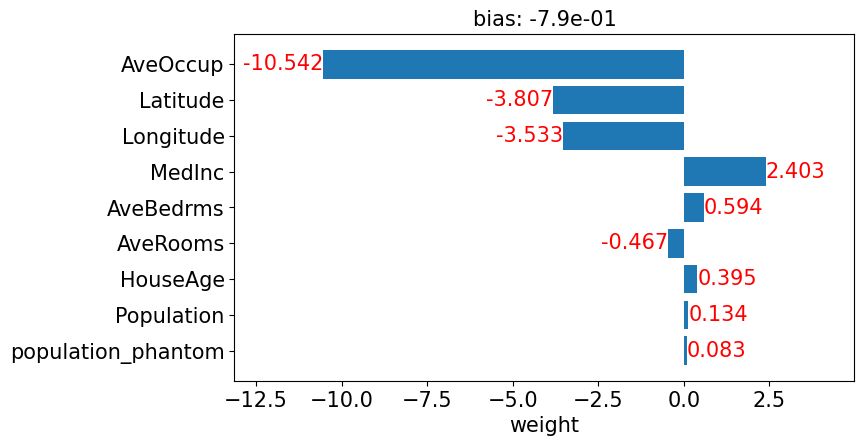

In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

model = LogisticRegression()

%time model.fit(tr[features].values, tr.target)

y_prob = model.predict_proba(val[features].values)

round(roc_auc_score(val.target, y_prob[:, 1]), 3)

from utils import plot_weights

plot_weights(model, features)

**боец: CMAESampler**

In [51]:
%%time
from scipy.special import expit
from sklearn.metrics import log_loss

def objective(trial, X_val, y_val):
    weights = []
    for i in range(9 + 1): # num_features + bias
        weight = trial.suggest_float(f'w_{i}', -5, 5)
        weights.append(weight)
    weights = np.array(weights)
    logits = X_val.dot(weights[1:]) + weights[0] # bias
    score = log_loss(y_val, expit(logits))
    return score

study = optuna.create_study(direction='minimize', sampler=optuna.samplers.CmaEsSampler())
func = partial(objective, X_val=val[features], y_val=val.target)

study.optimize(func, n_trials=1000, n_jobs=10)

[W 2025-04-08 20:29:19,093] Trial 10 failed with parameters: {} because of the following error: ModuleNotFoundError("No module named 'cmaes'").
Traceback (most recent call last):
  File "f:\anaconda\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "<timed exec>", line 7, in objective
  File "f:\anaconda\Lib\site-packages\optuna\trial\_trial.py", line 161, in suggest_float
    suggested_value = self._suggest(name, distribution)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "f:\anaconda\Lib\site-packages\optuna\trial\_trial.py", line 627, in _suggest
    elif self._is_relative_param(name, distribution):
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "f:\anaconda\Lib\site-packages\optuna\trial\_trial.py", line 659, in _is_relative_param
    if name not in self.relative_params:
                   ^^^^^^^^^^^^^^^^^^^^
  File "f:\anaconda\Lib\site-packages\optuna\tria

ModuleNotFoundError: No module named 'cmaes'

In [52]:
weights = np.array(list(study.best_trial.params.values()))
study.best_trial.params

{'w_0': -3.048019077550641,
 'w_1': 0.85615269956301,
 'w_2': 2.9169565381753273,
 'w_3': 3.5413157658340104,
 'w_4': -3.0464038478453173,
 'w_5': 2.3074879028396333,
 'w_6': -4.003378495171748,
 'w_7': -4.05240373166417,
 'w_8': -4.869370655629597,
 'w_9': -3.5056085946139737}

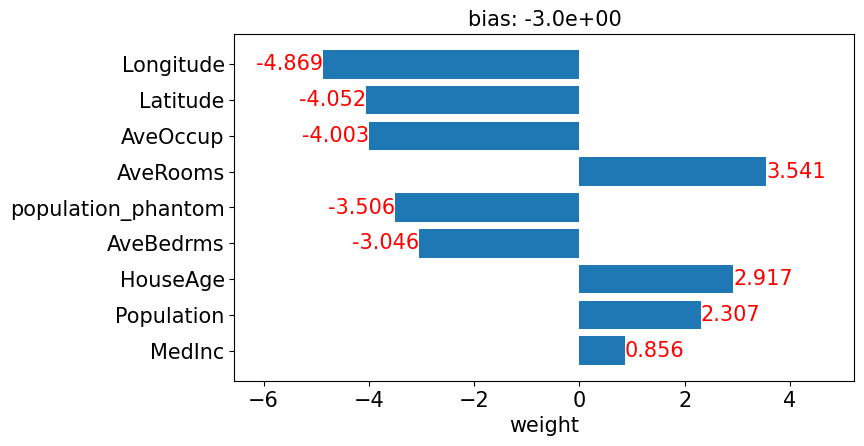

In [53]:
%load_ext autoreload
%autoreload 2
    
logits = val[features].values.dot(weights[1:]) + weights[0] # bias
roc_auc_score(val.target, logits)

plot_weights(features=features, weights=weights[1:], bias=weights[0])

### [Блог](https://medium.com/optuna) optuna на medium

требует VPN

там разработчики рассказывают о новых фишках

### [`optuna.pruners`](https://optuna.readthedocs.io/en/v3.4.0/reference/pruners.html)

это уже слишком advanced, поэтому out of scope - возможно, во втором семестре

### optuna [Dashboard](https://github.com/optuna/optuna-dashboard)

можно подключить, если вы сильно увлекаетесь оптимизацией гиперпараметров (чего делать не стоит)

### Что еще не прошли?